In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import timeit
# import seaborn as sns

#these are user defined modules
import plot
import calculate


# CAREER_LENGTH = 15 means the authors who have atleast 15 years of experience
CAREER_LENGTH_LIST = [0,5,10,15,20,25]
CAREER_LENGTH = 15
END_YEAR = 2015


## Cohort Analysis

For each (filtered) cohort analyze how the distribution of publications and citations changes in the cohort over time.
At the beginning all scientists should be equal (they have zero publications and citations). Over time some scientists become more productive and/or successful than others which leads to an increase in the Gini coefficient.

### Read Gender details

In [68]:
# read gender details - the column names are name, gender - change it to author, gender
gender = pd.read_csv('./data/name_gender_2017_asiansAsNone_nodup.txt')
gender.rename(columns={'name':'author'}, inplace=True)

In [69]:
print(gender.shape)
gender = gender.drop_duplicates()
print(gender.shape)
# Gender file is full of duplicates. As we use the author's name as ID, duplicate entries provide no extra info

(1704919, 2)
(1704919, 2)


In [70]:
gender_stats = gender.groupby('gender').size().to_frame()
gender_stats.columns = ['count']
gender_total = gender_stats['count'].sum()
gender_stats['percentage'] = gender_stats['count'].apply(lambda x: x/gender_total*100)
print("Number of unique authors: ", gender['author'].nunique())
gender_stats.head()

Number of unique authors:  1704919


,count,percentage
gender,,
f,255793,15.003235
m,796975,46.745623
none,652151,38.251143


### Read authors with start and end year details

In [71]:
# Different files exists depending upon their career length

#authorStartEndCareerData = pd.read_csv('./data/authors-scientific-atleast-'+str(CAREER_LENGTH)+'-year.csv')
authorStartEndCareerData = pd.read_csv('./data/authors-scientific-atleast-'+str(CAREER_LENGTH)+'-year.csv')


print('authorStartEndCareerData before filtering - ',authorStartEndCareerData.shape[0])
authorStartEndCareerData = authorStartEndCareerData[authorStartEndCareerData["start_year"] >= 1970]
print('authorStartEndCareerData after filtering - ',authorStartEndCareerData.shape[0])

print("author unique names  - ", authorStartEndCareerData['author'].nunique())
authorStartEndCareerData.head()

authorStartEndCareerData before filtering -  129022
authorStartEndCareerData after filtering -  129022
author unique names  -  129022


,author,start_year,end_year,num_pub,career_length
0,'maseka lesaoana,2001,2015,2,15
1,a min tjoa,1979,2017,191,39
2,a-imam al-sammak,1992,2006,3,15
3,a-xing zhu,1998,2017,22,20
4,a. a. (louis) beex,1980,2016,31,37


### Merge credible authors and their gender information

In [72]:
authorStartEndCareerData = pd.merge(authorStartEndCareerData, gender, how="left", on=["author"])
# for authors whose gender not found, replace it with none
authorStartEndCareerData['gender'] = authorStartEndCareerData['gender'].fillna('none')
authorStartEndCareerData.rename(columns={'num_pub':'total_num_pub'}, inplace=True)
# print("authorStartEndCareerData with duplicates: ", authorStartEndCareerData.shape[0])
# authorStartEndCareerData = authorStartEndCareerData.drop_duplicates()
print("authorStartEndCareerData no duplicates: ", authorStartEndCareerData.shape[0])

authorStartEndCareerData.head()

authorStartEndCareerData no duplicates:  129022


,author,start_year,end_year,total_num_pub,career_length,gender
0,'maseka lesaoana,2001,2015,2,15,none
1,a min tjoa,1979,2017,191,39,none
2,a-imam al-sammak,1992,2006,3,15,m
3,a-xing zhu,1998,2017,22,20,none
4,a. a. (louis) beex,1980,2016,31,37,m


In [73]:
#axes = authorStartEndCareerData.boxplot(column='pub_count', by='gender', return_type='axes')
#for ax in axes.values():
#    ax.set_ylim(0, 200)
#plt.show()

### Read Publication data

In [74]:
authorPublicationData = pd.read_csv('./data/author_publications_2017_asiansAsNone.txt')
print('authorPublicationData before filtering - ',authorPublicationData.shape[0])
authorPublicationData = authorPublicationData[authorPublicationData["year"] >= 1970]
print('authorPublicationData after filtering - ',authorPublicationData.shape[0])

authorPublicationData = authorPublicationData.groupby(['year','author']).count().reset_index()
authorPublicationData.rename(columns={'pub_id':'num_pub'}, inplace=True)

print(np.unique(authorStartEndCareerData["start_year"]))

authorPublicationData.head()

authorPublicationData before filtering -  9471668
authorPublicationData after filtering -  9462275
[1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983
 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997
 1998 1999 2000 2001 2002 2003 2004]


,year,author,num_pub
0,1970,a. a. afifi,1
1,1970,a. armenti,1
2,1970,a. c. mckellar,1
3,1970,a. c. williams,1
4,1970,a. colin day,1


### Merge Publications with credible authors and their gender information

In [75]:
authorPublicationData = pd.merge(authorPublicationData, authorStartEndCareerData, how="inner", on=["author"])


print("authorPublicationData before filtering: ", authorPublicationData.shape[0])
authorPublicationData = authorPublicationData.dropna(how='any')
print("authorPublicationData after filtering: ", authorPublicationData.shape[0])

print("authorPublicationData with duplicates: ", authorPublicationData.shape[0])
authorPublicationData = authorPublicationData.drop_duplicates()
print("authorPublicationData no duplicates: ", authorPublicationData.shape[0])

#print(authorPublicationData.head(n=2))
print(authorPublicationData['author'].nunique())
#print(authorPublicationData.shape[0])


#print(authorPublicationData[authorPublicationData.author=="a min tjoa"])
authorPublicationData.head()

authorPublicationData before filtering:  1449200
authorPublicationData after filtering:  1449200
authorPublicationData with duplicates:  1449200
authorPublicationData no duplicates:  1449200
129022


,year,author,num_pub,start_year,end_year,total_num_pub,career_length,gender
0,1970,a. moore,1,1970,2012,2,43,m
1,2012,a. moore,1,1970,2012,2,43,m
2,1970,a. trew,1,1970,2008,2,39,m
3,2008,a. trew,1,1970,2008,2,39,m
4,1970,adeline paiement,1,1970,2017,11,48,f


/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


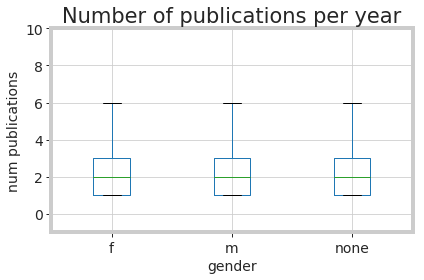

In [76]:
pl = authorPublicationData.boxplot(column='num_pub', by='gender', showfliers=False)
plt.title("Number of publications per year")
plt.suptitle("")
pl.set_xlabel('gender')
pl.set_ylabel('num publications')
pl.set_ylim([-1,10])
plt.show()

/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


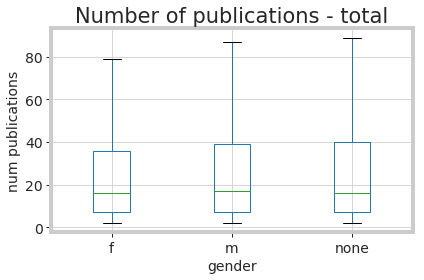

In [77]:
ax = authorStartEndCareerData.boxplot(column='total_num_pub', by='gender', showfliers=False)
plt.title("Number of publications - total")
plt.suptitle("")
ax.set_xlabel('gender')
ax.set_ylabel('num publications')
# fig.set_tight_layout(False)
plt.show()

### Test Data ???

In [78]:
print(authorPublicationData.head(n=1))

groupByYearData = authorPublicationData.copy(deep=True)
print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(3))
print(np.unique(groupByYearData["year"]))

groupByYearData = calculate.groupDataAndCalculateCumulativeValues(groupByYearData, 1, 'num_pub')
print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(3))
print(np.unique(groupByYearData["year"]))

   year    author  num_pub  start_year  end_year  total_num_pub  \
0  1970  a. moore        1        1970      2012              2   

   career_length gender  
0             43      m  
        year            author  num_pub  start_year  end_year  total_num_pub  \
267601  1987  donatella sciuto        1        1987      2016            349   
267602  1988  donatella sciuto        2        1987      2016            349   
267603  1989  donatella sciuto        1        1987      2016            349   

        career_length gender  
267601             30      f  
267602             30      f  
267603             30      f  
[1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983
 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997
 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011
 2012 2013 2014 2015 2016 2017 2018]
       year            author  num_pub  start_year  end_year  total_num_pub  \
45940  1987  donatella sciuto        1 

# Cohort Analysis on all authors for 15 years

In [79]:
years = groupByYearData['year'].unique()
years = sorted(years)
print(years)

[1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]


### Select Cohorts based on Start Years

In [80]:
cohort_start_years = [y for y in years if y < (END_YEAR - CAREER_LENGTH)]
#cohort_start_years = [1970, 1974, 1984, 1994, 1998]



### Cohort Analysis (Num Pub)

In [81]:
# from importlib import reload
# reload(plot)

   year         author  num_pub  start_year  end_year  total_num_pub  \
0  1970       a. moore        1        1970      2012              2   
1  1970  tomoko suzuki        1        1970      2010              9   
2  1970  tomoaki miura        1        1970      2016             23   

   career_length gender  cum_num_pub  
0             43      m            1  
1             41      f            1  
2             47      m            1  


/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/home/danielkostic/anaconda3/li

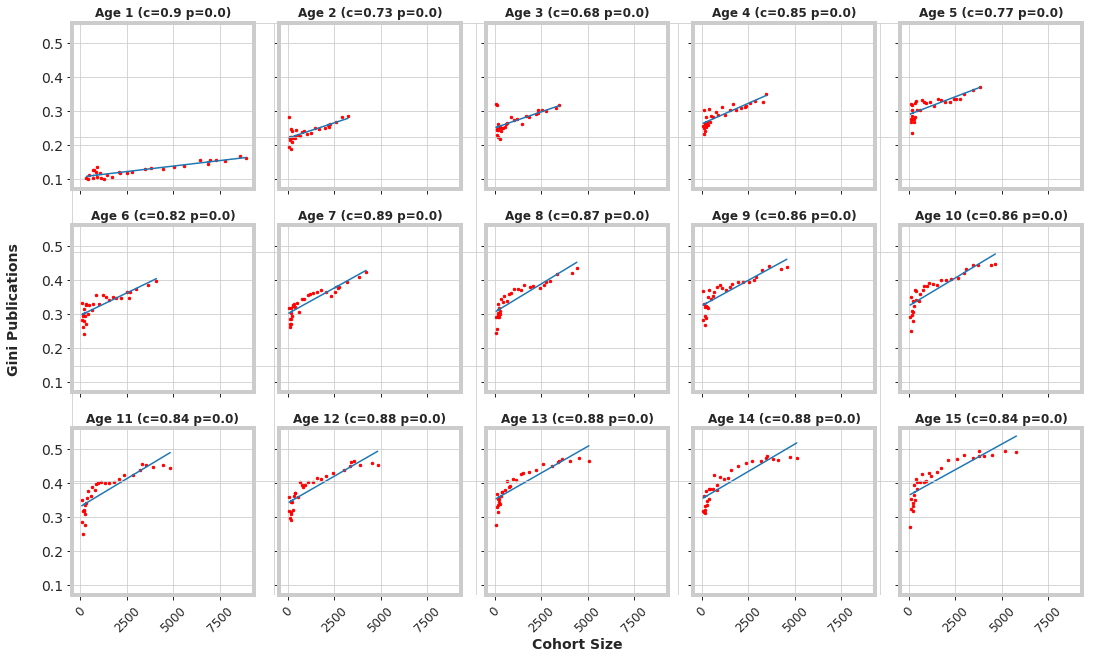

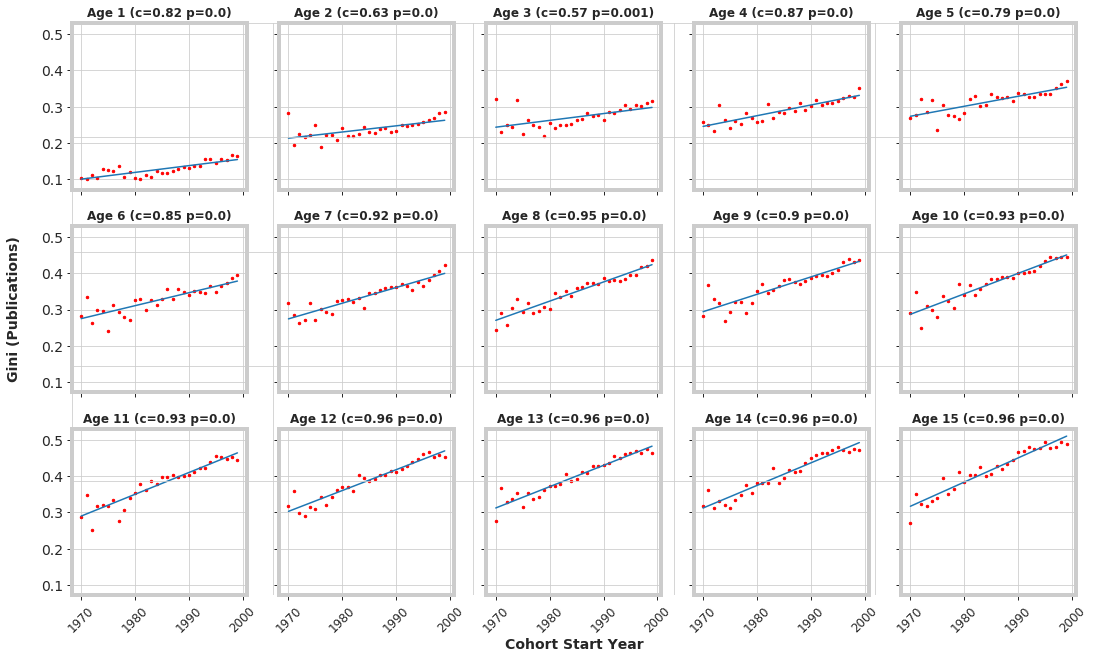

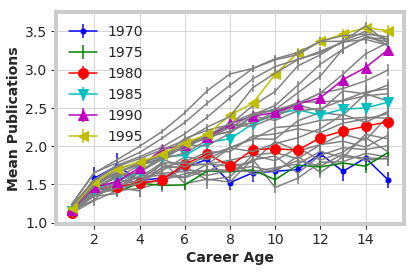

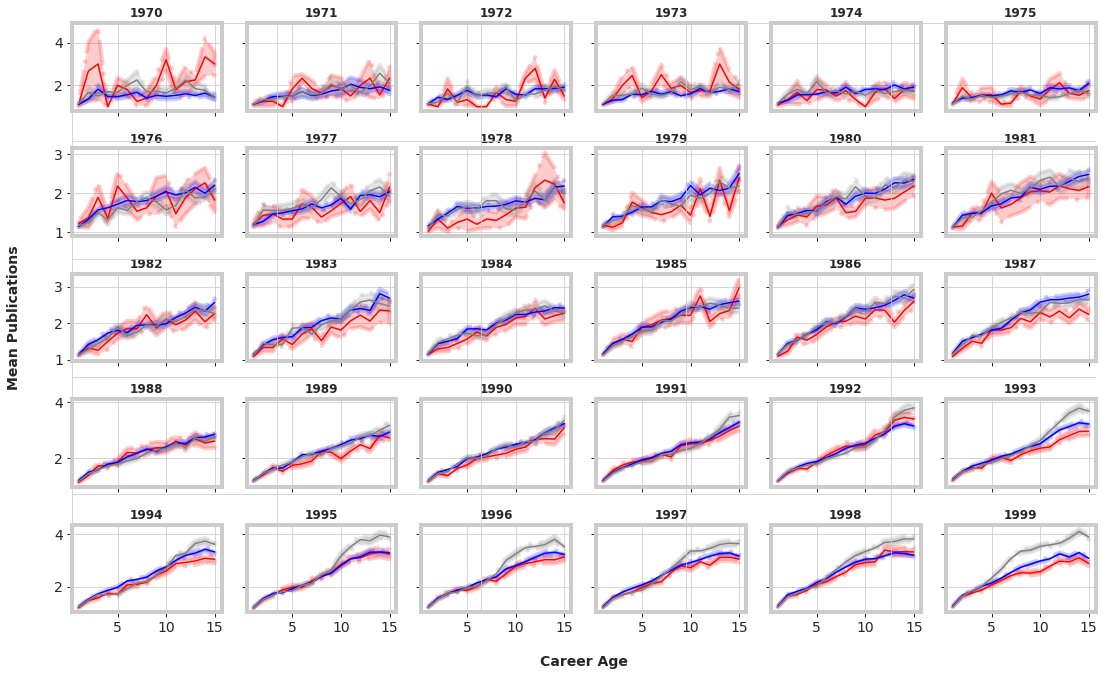

In [82]:
plot.run_cohort_analysis(groupByYearData, cohort_start_years, CAREER_LENGTH, "num_pub", "Publications")  

### Cohort Analysis (Cum Num Pub)

   year         author  num_pub  start_year  end_year  total_num_pub  \
0  1970       a. moore        1        1970      2012              2   
1  1970  tomoko suzuki        1        1970      2010              9   
2  1970  tomoaki miura        1        1970      2016             23   

   career_length gender  cum_num_pub  
0             43      m            1  
1             41      f            1  
2             47      m            1  


/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/home/danielkostic/anaconda3/li

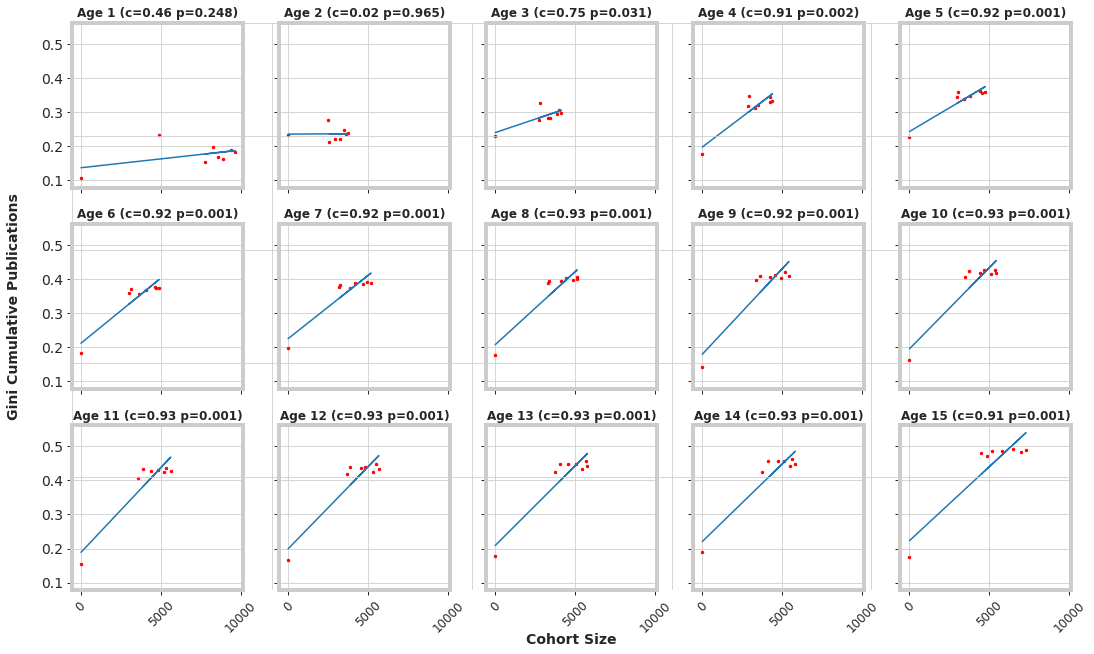

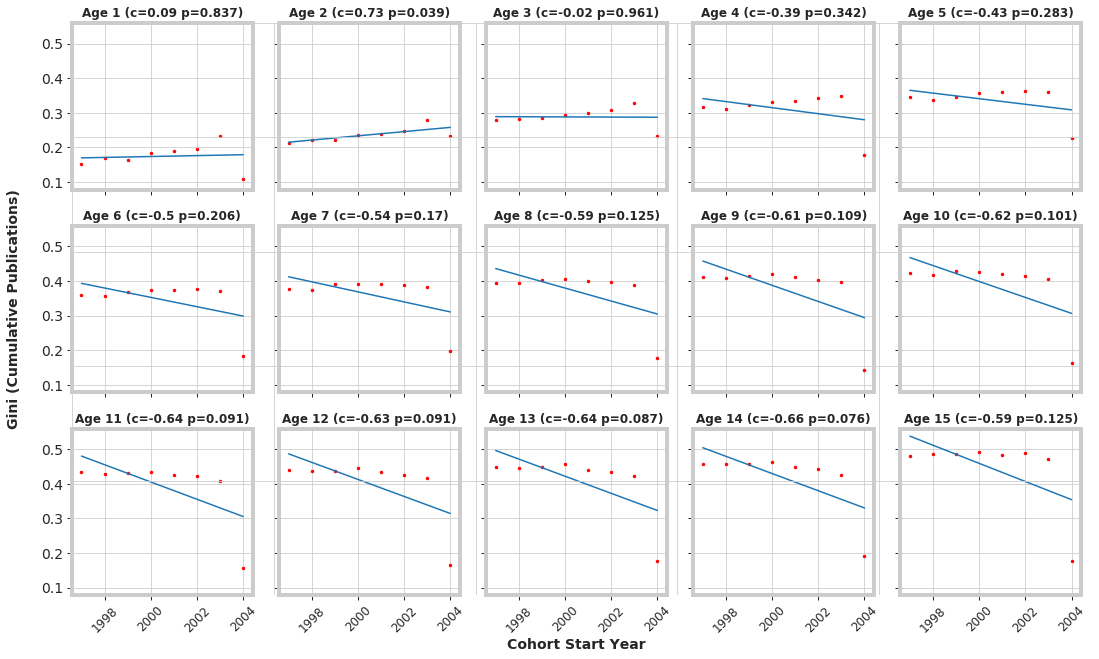

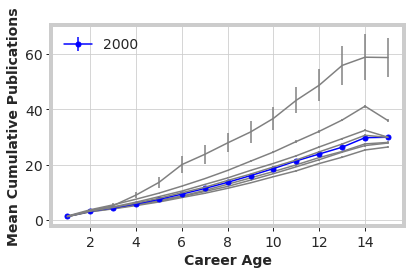

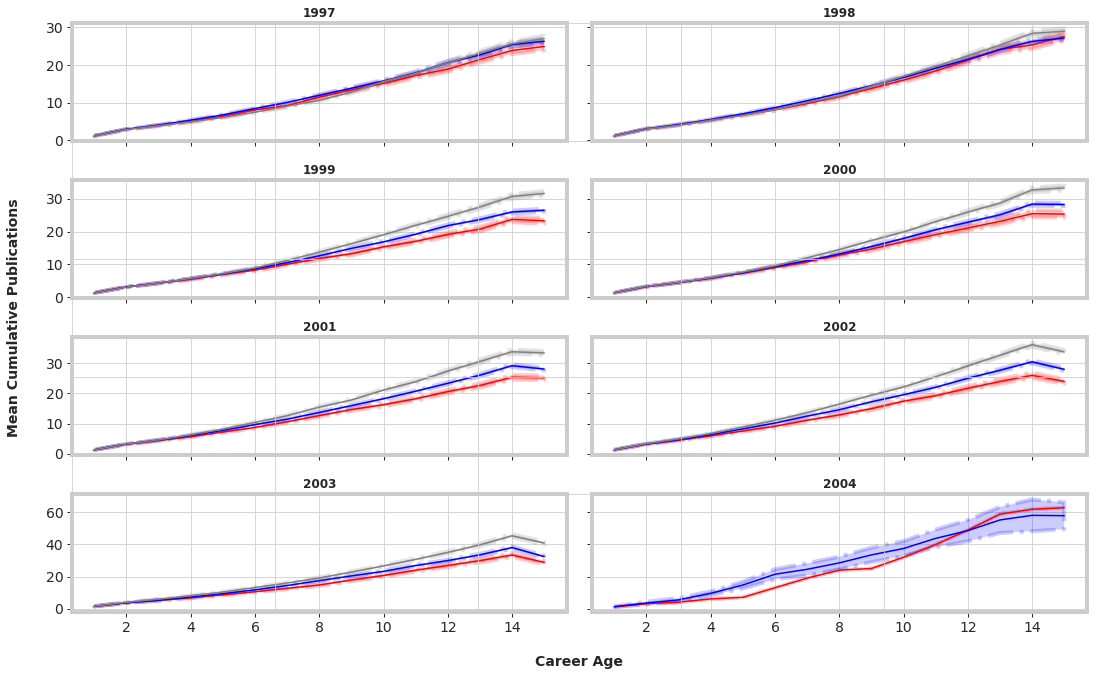

In [89]:
# from importlib import reload
# reload(plot)
plot.run_cohort_analysis(groupByYearData, cohort_start_years, CAREER_LENGTH, "cum_num_pub", "Cumulative Publications")  


### Cumulative Distribution of selected Cohorts for selected Career Ages

how do the distributions differ? 

   year         author  num_pub  start_year  end_year  total_num_pub  \
0  1970       a. moore        1        1970      2012              2   
1  1970  tomoko suzuki        1        1970      2010              9   
2  1970  tomoaki miura        1        1970      2016             23   

   career_length gender  cum_num_pub  
0             43      m            1  
1             41      f            1  
2             47      m            1  
  year:1997    age: 1
Counter({1.0: 6504, 2.0: 983, 3.0: 228, 4.0: 46, 5.0: 11, 6.0: 3, 7.0: 1, 10.0: 1, 11.0: 1})
  year:1998    age: 1
Counter({1.0: 6997, 2.0: 1199, 3.0: 261, 4.0: 69, 5.0: 25, 6.0: 8, 8.0: 2, 10.0: 1})
  year:1999    age: 1
Counter({1.0: 7267, 2.0: 1265, 3.0: 248, 4.0: 66, 5.0: 19, 6.0: 7, 7.0: 2, 10.0: 1})
  year:2000    age: 1
Counter({1.0: 7575, 2.0: 1579, 3.0: 343, 4.0: 103, 5.0: 24, 7.0: 8, 6.0: 2, 9.0: 1, 10.0: 1})
  year:2001    age: 1
Counter({1.0: 7411, 2.0: 1435, 3.0: 368, 4.0: 94, 5.0: 34, 6.0: 14, 7.0: 6, 8.0: 3})
  y

/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


  year:1997    age: 5
Counter({1.0: 1591, 2.0: 701, 3.0: 306, 4.0: 178, 5.0: 81, 6.0: 51, 7.0: 22, 8.0: 16, 9.0: 12, 10.0: 4, 11.0: 3, 12.0: 3, 13.0: 1, 17.0: 1, 20.0: 1, 30.0: 1})
  year:1998    age: 5
Counter({1.0: 1733, 2.0: 796, 3.0: 402, 4.0: 217, 5.0: 136, 6.0: 60, 7.0: 27, 8.0: 15, 9.0: 13, 10.0: 11, 11.0: 7, 12.0: 4, 14.0: 3, 13.0: 2, 16.0: 2, 15.0: 1})
  year:1999    age: 5
Counter({1.0: 1825, 2.0: 946, 3.0: 472, 4.0: 219, 5.0: 131, 6.0: 84, 7.0: 45, 8.0: 21, 11.0: 16, 10.0: 12, 9.0: 8, 12.0: 8, 13.0: 5, 16.0: 4, 14.0: 3, 17.0: 2, 15.0: 1})
  year:2000    age: 5
Counter({1.0: 2089, 2.0: 1075, 3.0: 562, 4.0: 290, 5.0: 164, 6.0: 123, 7.0: 56, 8.0: 54, 10.0: 28, 9.0: 27, 11.0: 12, 12.0: 11, 13.0: 6, 14.0: 4, 16.0: 3, 15.0: 2, 17.0: 2, 18.0: 1, 21.0: 1, 29.0: 1})
  year:2001    age: 5
Counter({1.0: 2014, 2.0: 1160, 3.0: 616, 4.0: 336, 5.0: 214, 6.0: 140, 7.0: 99, 8.0: 56, 9.0: 29, 10.0: 22, 11.0: 14, 12.0: 10, 13.0: 10, 15.0: 3, 16.0: 3, 18.0: 3, 14.0: 2, 17.0: 1, 20.0: 1, 23.0: 1

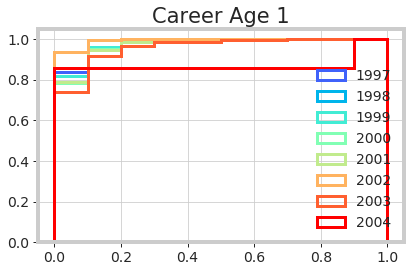

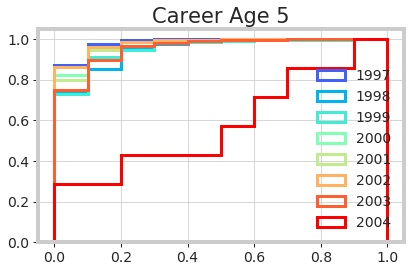

In [84]:
cohort_start_years = [1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004]

cohort_careerage_df = plot.get_cohort_careerage_df(groupByYearData, cohort_start_years, CAREER_LENGTH, 'num_pub')
plot.plot_cumulative_dist(cohort_careerage_df, 1, 'num_pub', 'Number of Publications')
plot.plot_cumulative_dist(cohort_careerage_df, 5, 'num_pub', 'Number of Publications')
# plot.plot_cumulative_dist(cohort_careerage_df, 10, 'num_pub', 'Number of Publications')
# plot.plot_cumulative_dist(cohort_careerage_df, 15, 'num_pub', 'Number of Publications')



### Regression Analysis of mean productivity on Inequality for all authors for 15 years

- There is no relation at all - Reg. coefficient is 0

In [85]:
#just for debugging
#reload(plot)
#reload(calculate)
#data = plot.plot_regress_performance_on_inequality(groupByYearData, 'num_pub', years, CAREER_LENGTH)


In [86]:
#just for debugging
#reload(plot)
#reload(calculate)
#data = plot.plot_regress_performance_on_inequality(groupByYearData, 'cum_num_pub', years, CAREER_LENGTH)

### Cohort Analysis, Regression analysis on authors grouped by 2 years for 15 years

Regression???
outcome variable: inequality of each cohort an each time interval (2 years)
Indepent variable: number of publications that the cohort produced during the time interval

Question: are more inequal groups, more productive?  

In [87]:
#groupByYearData = authorPublicationData.copy(deep=True)
#print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))
#groupByYearData = calculate.groupDataAndCalculateCumulativeValues(groupByYearData, 2, 'num_pub')
#print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))

#years = groupByYearData['year'].unique()
#years = sorted(years)
#print(years)

#plot.plot_cohort_analysis_on(groupByYearData, 'num_pub', cohort_start_years, CAREER_LENGTH, 'Publications Count')
#plot.plot_cohort_analysis_on(groupByYearData, 'cum_num_pub', cohort_start_years, CAREER_LENGTH, 'Cumulative Publications Count')
#data1 = plot.plot_regress_performance_on_inequality(groupByYearData, 'num_pub', years, CAREER_LENGTH)
#data2 = plot.plot_regress_performance_on_inequality(groupByYearData, 'cum_num_pub', years, CAREER_LENGTH)

### Cohort Analysis, Regression analysis on authors grouped by 3 years for 15 years

In [88]:
#groupByYearData = authorPublicationData.copy(deep=True)
#print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))
#groupByYearData = calculate.groupDataAndCalculateCumulativeValues(groupByYearData, 3, 'num_pub')
#print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))

#years = groupByYearData['year'].unique()
#years = sorted(years)
#print(years)

#plot.plot_cohort_analysis_on(groupByYearData, 'num_pub', cohort_start_years, CAREER_LENGTH, 'Publications Count')
#plot.plot_cohort_analysis_on(groupByYearData, 'cum_num_pub', cohort_start_years, CAREER_LENGTH, 'Cumulative Publications Count')
#data1 = plot.plot_regress_performance_on_inequality(groupByYearData, 'num_pub', years, CAREER_LENGTH)
#data2 = plot.plot_regress_performance_on_inequality(groupByYearData, 'cum_num_pub', years, CAREER_LENGTH)